<a href="https://colab.research.google.com/github/Ayanp345/DeepSphere-spherical-CNN/blob/main/DeepSphere_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
!pip install healpy
import healpy as hp
import tensorflow as tf
from tensorflow.keras import layers, models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 89.9 MB/s eta 0:00:00


In [6]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

In [7]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, y_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(50000, 32, 32, 3) (50000, 1)


In [8]:
NSIDE = 8                       # valid HEALPix resolution
NPIX = hp.nside2npix(NSIDE)     # = 768

print("Number of spherical nodes:", NPIX)


Number of spherical nodes: 768


In [9]:
def image_to_sphere(image):
    gray = np.mean(image, axis=-1)
    flat = gray.flatten()
    if len(flat) >= NPIX:
        return flat[:NPIX]
    else:
        return np.pad(flat, (0, NPIX - len(flat)))


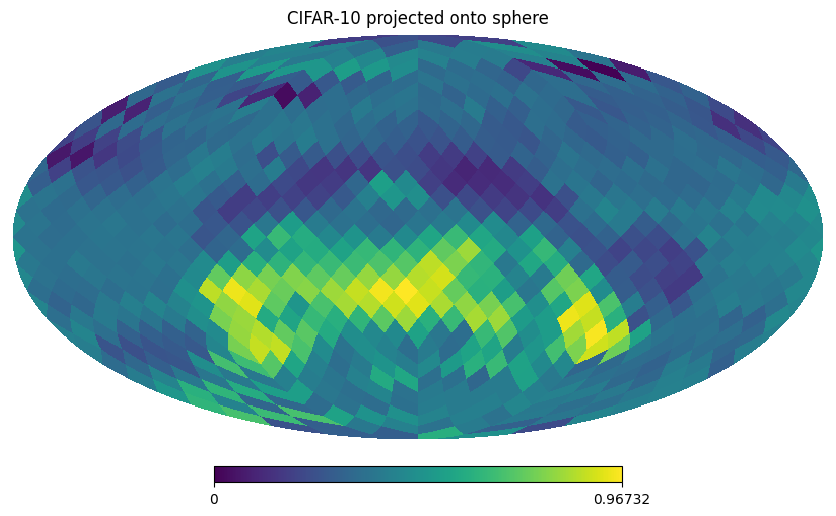

In [10]:
sample = image_to_sphere(x_train[0])
hp.mollview(sample, title="CIFAR-10 projected onto sphere")
plt.show()

In [11]:
def prepare_dataset(X):
    data = np.array([image_to_sphere(img) for img in X])
    data = (data - data.mean()) / data.std()   # normalization
    return data

X_train_sph = prepare_dataset(x_train[:5000])
X_test_sph  = prepare_dataset(x_test[:1000])

y_train_sph = y_train[:5000]
y_test_sph  = y_test[:1000]

print(X_train_sph.shape, y_train_sph.shape)

(5000, 768) (5000, 1)


In [12]:
# Build Laplacian matrix
def build_laplacian(NSIDE):
    NPIX = hp.nside2npix(NSIDE)
    neighbors = [hp.get_all_neighbours(NSIDE, i) for i in range(NPIX)]

    W = np.zeros((NPIX, NPIX))
    for i, nbrs in enumerate(neighbors):
        valid_nbrs = nbrs[nbrs >= 0]
        W[i, valid_nbrs] = 1

    W = W + W.T  # symmetrize
    degrees = W.sum(axis=1)
    D = np.diag(degrees)
    L = D - W

    return L

L = build_laplacian(NSIDE)

print("Laplacian shape:", L.shape)

Laplacian shape: (768, 768)


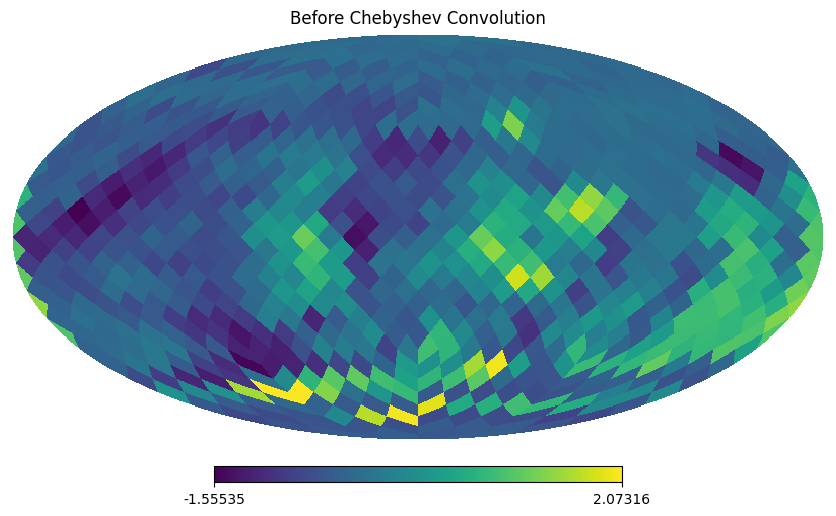

In [13]:
# Chebyshev convolution function
def chebyshev_convolution(signal, L, K=3):
    """
    Chebyshev polynomial graph convolution.
    L: Graph Laplacian (NPIX x NPIX)
    K: Order of Chebyshev polynomial
    """
    # Rescale Laplacian to [-1, 1]
    lmax = np.max(np.linalg.eigvalsh(L))
    L_scaled = (2.0 / lmax) * L - np.eye(L.shape[0])

    # Chebyshev recursion
    Tx = [signal]
    if K > 1:
        Tx.append(L_scaled @ signal)
        for k in range(2, K):
            Tx.append(2 * L_scaled @ Tx[-1] - Tx[-2])

    # Weighted sum (dummy weights for demonstration)
    weights = np.random.randn(K)
    output = np.zeros_like(signal)
    for k in range(K):
        output += weights[k] * Tx[k]
    return output

# Example usage
idx = 0
original = X_test_sph[idx]
smoothed = chebyshev_convolution(original, L, K=3)

# Plot original activations
hp.mollview(
    original,
    title="Before Chebyshev Convolution",
    cmap="viridis"
)
plt.show()

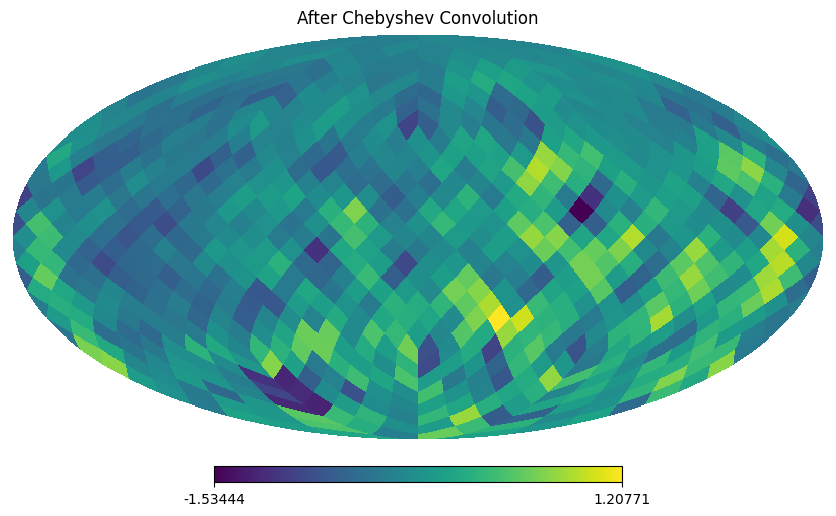

In [14]:
# Plot after Chebyshev convolution
hp.mollview(
    smoothed,
    title="After Chebyshev Convolution",
    cmap="viridis"
)
plt.show()

In [15]:
class ChebConvLayer(tf.keras.layers.Layer):
    def __init__(self, L, K, units, **kwargs):
        super().__init__(**kwargs)
        self.K = K
        self.units = units
        self.N = L.shape[0]

        # Scale Laplacian
        lmax = np.max(np.linalg.eigvalsh(L))
        L_scaled = (2.0 / lmax) * L - np.eye(self.N)
        self.L_scaled = tf.constant(L_scaled, dtype=tf.float32)

    def build(self, input_shape):
        self.cheb_weights = self.add_weight(
            name="cheb_weights",
            shape=(self.K, self.N, self.units),
            initializer="glorot_uniform",
            trainable=True
        )

        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        # inputs: (batch, NPIX)
        batch_size = tf.shape(inputs)[0]

        outputs = tf.zeros((batch_size, self.units))

        x = inputs
        for k in range(self.K):
            # (batch, NPIX)
            x = tf.matmul(x, self.L_scaled)

            # (batch, units)
            outputs += tf.matmul(x, self.cheb_weights[k])

        return outputs + self.bias

In [16]:
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Input(shape=(NPIX,)),

    layers.Dense(
        256,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.Dropout(0.5),

    layers.Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.Dropout(0.4),

    layers.Dense(10, activation="softmax")
])



from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # watch validation loss
    patience=5,              # stop after 5 epochs without improvement
    restore_best_weights=True
)

In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_sph, y_train_sph,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1453 - loss: 3.4203 - val_accuracy: 0.2400 - val_loss: 2.6989
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2006 - loss: 2.7716 - val_accuracy: 0.2370 - val_loss: 2.6682
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2342 - loss: 2.6628 - val_accuracy: 0.2620 - val_loss: 2.6319
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2458 - loss: 2.6107 - val_accuracy: 0.2620 - val_loss: 2.5628
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2570 - loss: 2.5445 - val_accuracy: 0.2840 - val_loss: 2.5115
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2930 - loss: 2.4850 - val_accuracy: 0.2790 - val_loss: 2.5014
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2908 - loss: 2.4704 - val_accuracy: 0.2900 - val_loss: 2.4797
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2679 - loss: 2.4107 - val_accuracy: 0

In [18]:
loss, acc = model.evaluate(X_test_sph, y_test_sph)
print("Test Accuracy:", acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3376 - loss: 2.1761
Test Accuracy: 0.34599998593330383


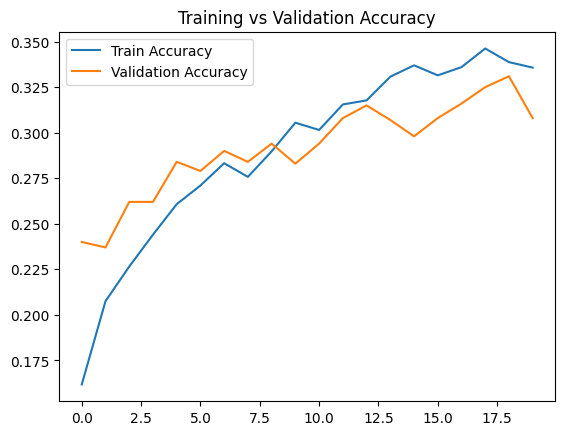

In [19]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

/tmp/ipython-input-1430559137.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_idx = int(y_test_sph[idx])


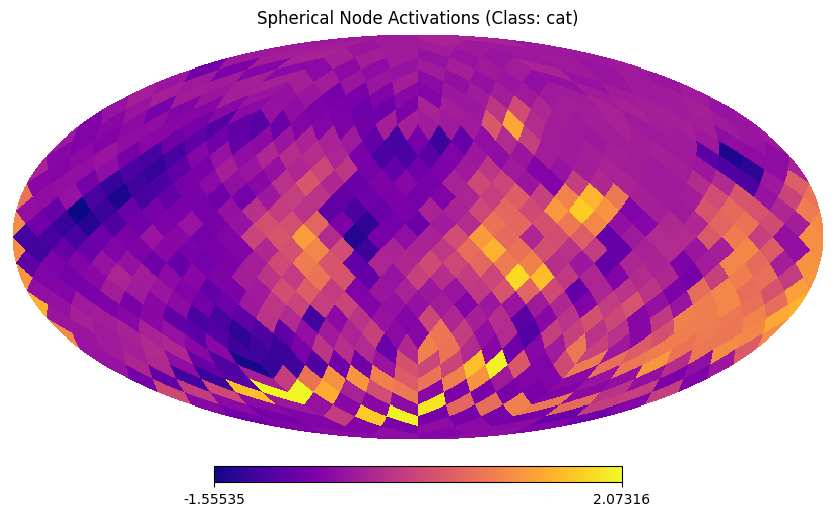

In [20]:
# index of the sample you want to visualize
idx = 0

# get class label
label_idx = int(y_test_sph[idx])
label_name = class_names[label_idx]

# visualize spherical node activations with class name
hp.mollview(
    X_test_sph[idx],
    title=f"Spherical Node Activations (Class: {label_name})",
    cmap="plasma"
)
plt.show()

In [21]:
# get neighbors for each node
neighbors = [hp.get_all_neighbours(NSIDE, i) for i in range(NPIX)]

In [22]:
def graph_convolution(signal, neighbors):
    new_signal = np.zeros_like(signal)
    for i, nbrs in enumerate(neighbors):
        valid_nbrs = nbrs[nbrs >= 0]  # remove invalid neighbors
        new_signal[i] = np.mean(signal[valid_nbrs])
    return new_signal


def chebyshev_convolution(signal, L, K=3):
    """
    Chebyshev polynomial graph convolution.
    L: Graph Laplacian (NPIX x NPIX)
    K: Order of Chebyshev polynomial
    """
    # Rescale Laplacian to [-1, 1]
    lmax = np.max(np.linalg.eigvalsh(L))
    L_scaled = (2.0 / lmax) * L - np.eye(L.shape[0])

    # Chebyshev recursion
    Tx = [signal]
    if K > 1:
        Tx.append(L_scaled @ signal)
        for k in range(2, K):
            Tx.append(2 * L_scaled @ Tx[-1] - Tx[-2])

    # Weighted sum (dummy weights for demonstration)
    weights = np.random.randn(K)
    output = np.zeros_like(signal)
    for k in range(K):
        output += weights[k] * Tx[k]
    return output

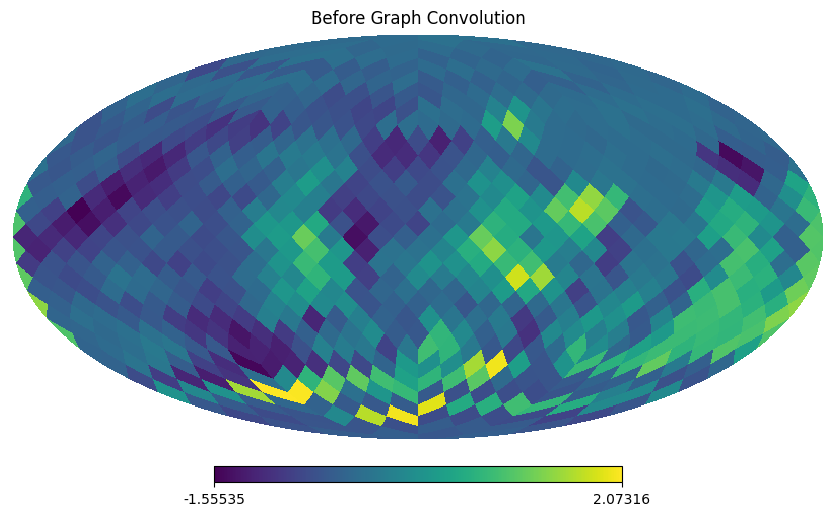

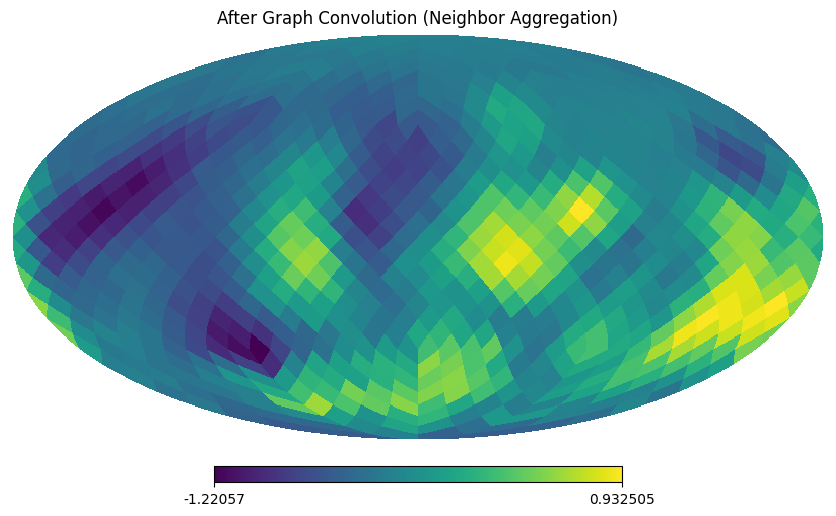

In [23]:
original = X_test_sph[idx]
smoothed = graph_convolution(original, neighbors)

# plot original activations
hp.mollview(
    original,
    title="Before Graph Convolution",
    cmap="viridis"
)
plt.show()

# plot after graph convolution
hp.mollview(
    smoothed,
    title="After Graph Convolution (Neighbor Aggregation)",
    cmap="viridis"
)
plt.show()